# Repeated Measures ANOVA

The repeated-measures ANOVA is used for analyzing data where same subjects are measured more than once. This test is also referred to as a within-subjects ANOVA or ANOVA with repeated measures. The “within-subjects” term means that the same individuals are measured on the same outcome variable under different time points or conditions.

In [4]:
#install.packages("tidyverse")

library(splitstackshape)
library(tidyverse)
library(ggpubr)
library(rstatix)
library(dplyr)
library (corrplot)

In [38]:
#path = "/software/trained/results/Mice/GSK/results_GSK_OCT_all.csv"
#path = "/software/trained/results/Mice/GSK/results_GSK_NOV_all.csv"
path = "/software/trained/results/Mice/GSK/results_GSK_JAN_all.csv"
#path = "/software/trained/results/Humans/LUNA16/results_LUNA16_all.csv"
#path = "/software/trained/results/Macaques/results_Macaques_Batch1_all.csv"
#path = "/software/trained/results/Humans/results_Imageclef_TrainingSet_all.csv"

In [39]:
name <- strsplit(path, "results_")
name <- strsplit(name[[1]], "_all.csv")
name <- name[[2]]

In [40]:

data <- read.csv(file = path,
                        stringsAsFactors = TRUE)
data <- select(data, Image,GT, Model, Rater, ROI, dice)

summary <- data %>%
	group_by(Model) %>%
	summarise(Mean = mean(dice), Variance = var(dice), Maximum = max(dice), Minimum = min(dice))

summary

Model,Mean,Variance,Maximum,Minimum
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
human_org,0.2960370,0.05843272,0.7420509,0.00000000
mice_TL,0.4627109,0.12339004,0.8630252,0.00000000
mix_No_TL,0.5893725,0.02873421,0.8455380,0.12137444
mix_No_TL_A,0.5729114,0.02569186,0.7124691,0.06526773
mix_No_TL_A_mac,0.5870933,0.05319030,0.8198814,0.00000000
mix_No_TL_mac,0.5818159,0.02687925,0.8391929,0.11946924
mix_TL,0.5856177,0.02498584,0.8662218,0.19884647
mix_TL_mac,0.5796663,0.02594862,0.8750006,0.18528369
mix_TL_mic,0.5809017,0.02433433,0.8688246,0.19765300


## Outliers and extreme points

First of all, we must identify outliers and extreme points.

Values above Q3 + 1.5xIQR or below Q1 - 1.5xIQR are considered as outliers. Values above Q3 + 3xIQR or below Q1 - 3xIQR are considered as extreme points (or extreme outliers).

Q1 and Q3 are the first and third quartile, respectively. IQR is the interquartile range (IQR = Q3 - Q1).

Generally speaking, data points that are labelled outliers in boxplots are not considered as troublesome as those considered extreme points and might even be ignored.

In [41]:
outliers <- data %>%
  group_by(Model) %>%
      identify_outliers(dice)

extremes <- outliers
extremes <- extremes[!grepl("FALSE", extremes$is.extreme),]


## Normality assumption

The normality assumption can be checked by computing Shapiro-Wilk test for each time point.
If the data is normally distributed, the p-value should be greater than 0.05.

### Shapiro Test

In [42]:
print("Shapiro Test for original data")
data %>%
  group_by(Model) %>%
  shapiro_test(dice)

[1] "Shapiro Test for original data"


Model,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
human_org,dice,0.9107442,4.731999e-04
mice_TL,dice,0.7967684,1.944347e-07
mix_No_TL,dice,0.8305187,3.286116e-03
mix_No_TL_A,dice,0.7459704,2.072356e-04
mix_No_TL_A_mac,dice,0.7742212,4.940657e-04
mix_No_TL_mac,dice,0.8231620,2.530489e-03
mix_TL,dice,0.8102473,1.616279e-03
mix_TL_mac,dice,0.8085849,1.527082e-03
mix_TL_mic,dice,0.8029208,1.260506e-03


In [43]:
eliminated<-data

eliminated<- eliminated[-which(eliminated$Image %in% extremes$Image),]

if (nrow(extremes)>0){
    print("Shapiro Test for data without extreme points")
    eliminated %>%
      group_by(Model) %>%
      shapiro_test(dice)
    }

[1] "Shapiro Test for data without extreme points"


Model,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
human_org,dice,0.9123045,1.608689e-03
mice_TL,dice,0.7414955,7.768576e-08
mix_No_TL,dice,0.9189033,1.619615e-01
mix_No_TL_A,dice,0.8247910,5.926576e-03
mix_No_TL_A_mac,dice,0.8598386,1.907722e-02
mix_No_TL_mac,dice,0.9052781,9.767847e-02
mix_TL,dice,0.8215898,5.348444e-03
mix_TL_mac,dice,0.7944933,2.303605e-03
mix_TL_mic,dice,0.7829123,1.629572e-03


### Q-Q Plot

If sample size is greater than 50, the normal Q-Q plot is preferred because at larger sample sizes the Shapiro-Wilk test becomes very sensitive even to a minor deviation from normality.

QQ plot draws the correlation between a given data and the normal distribution.

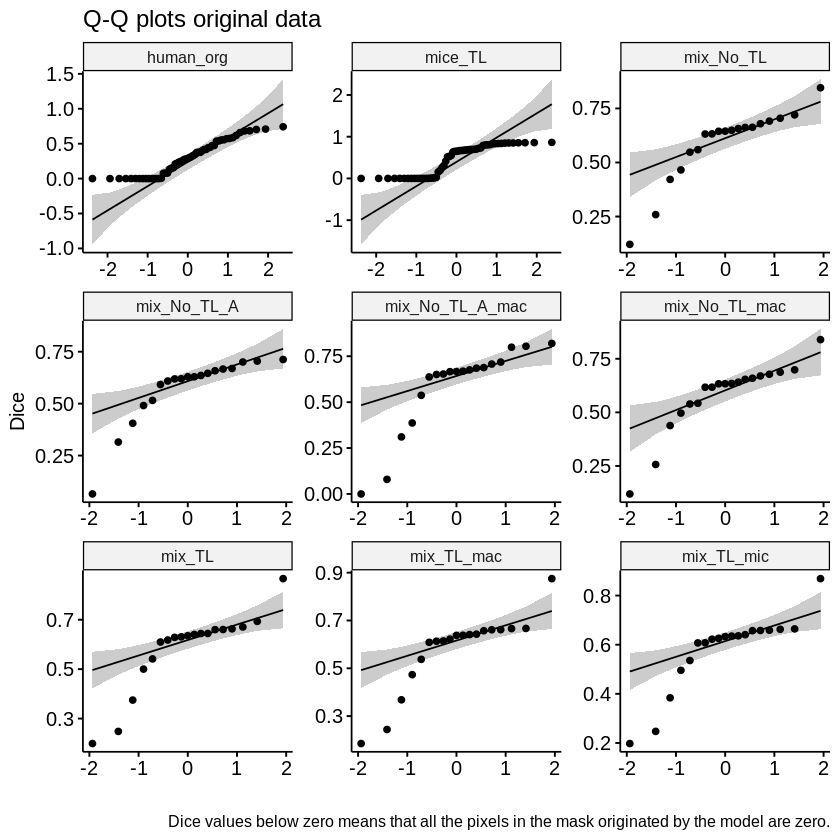

In [44]:
p <- ggqqplot(data, "dice") + 
     labs(title = "Q-Q plots original data",
          caption = "Dice values below zero means that all the pixels in the mask originated by the model are zero.", 
          x = "", y = "Dice")

facet(p,facet.by = "Model",scales='free')

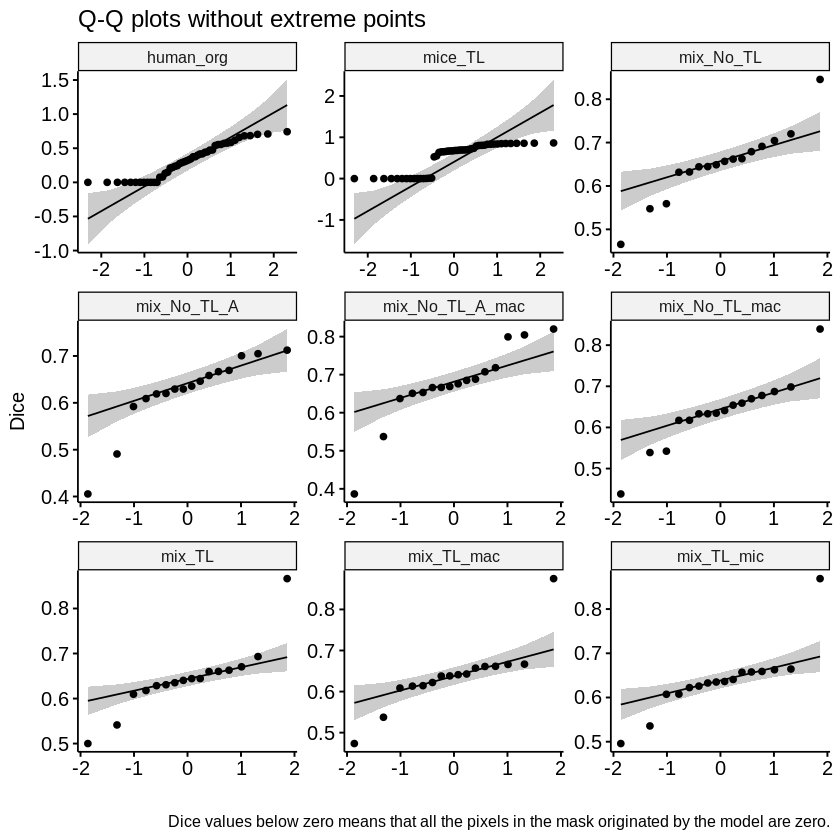

In [45]:
if (nrow(extremes)>0){
    p <- ggqqplot(eliminated, "dice") + 
         labs(title = "Q-Q plots without extreme points",
              caption = "Dice values below zero means that all the pixels in the mask originated by the model are zero.", 
              x = "", y = "Dice")

    facet(p,facet.by = "Model",scales='free')
    }

## ANOVA Test

In [46]:
print("Original Data")
res.aov <- anova_test(data = data, dv = dice, wid = c(Image,Rater,ROI,GT), within = Model)

alpha = 0.0001
df1 = res.aov[[1]][["DFn"]]
df2 = res.aov[[1]][["DFd"]]
cat("F critical value:", qf(1-alpha, df1=df1, df2=df2),"\n\n\n\n")

get_anova_table(res.aov)

[1] "Original Data"
F critical value: 4.353682 





,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Model,1.81,32.66,19.468,4.84e-06,*,0.202


In [47]:
if (nrow(extremes)>0){
    print("Data without Extreme Points")
    res2.aov <- anova_test(data = eliminated, dv = dice, wid = c(Image,Rater,ROI,GT), within = Model)

    df1 = res2.aov[[1]][["DFn"]]
    df2 = res2.aov[[1]][["DFd"]]
    cat("F critical value:", qf(1-alpha, df1=df1, df2=df2),"\n\n\n\n")
    
    get_anova_table(res2.aov)
    }

[1] "Data without Extreme Points"
F critical value: 4.433344 





,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Model,1.44,21.61,28.587,4.42e-06,*,0.517




Dice was statistically __significantly different__ between Models. 

If F value is larger than F critical value, null hypothesis can be rejected. However, it is recommended to consider also the p value.
- p < 0.0001
- F value > F critical value.

## Post Hoc Test
Once it is known that there is significant difference between models, post hoc test are run to confirm where the differences occurred between groups.

### Bonferroni Correction
The Bonferroni correction is a __*multiple-comparison*__ correction used when several dependent or independent statistical tests are being performed simultaneously.

In [48]:
pwc <- data %>%
  pairwise_t_test(
    dice ~ Model, paired = FALSE,
    p.adjust.method = "bonferroni"
    )
#pwc
if (nrow(extremes)>0){
pwc_no_extreme <- eliminated %>%
  pairwise_t_test(
    dice ~ Model, paired = FALSE,
    p.adjust.method = "bonferroni"
    )
#pwc
    }

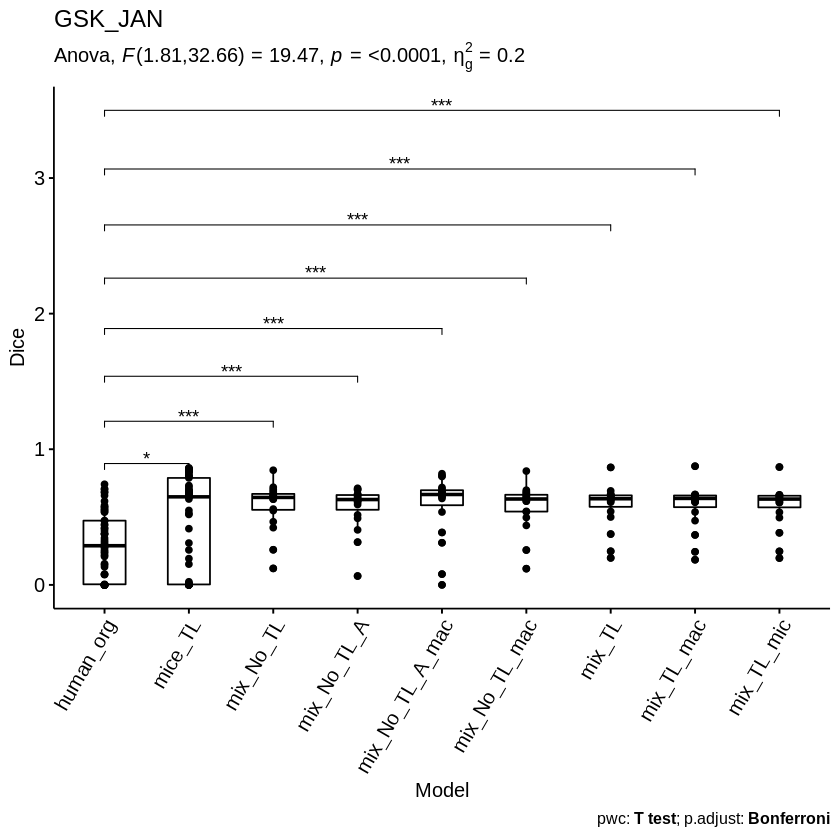

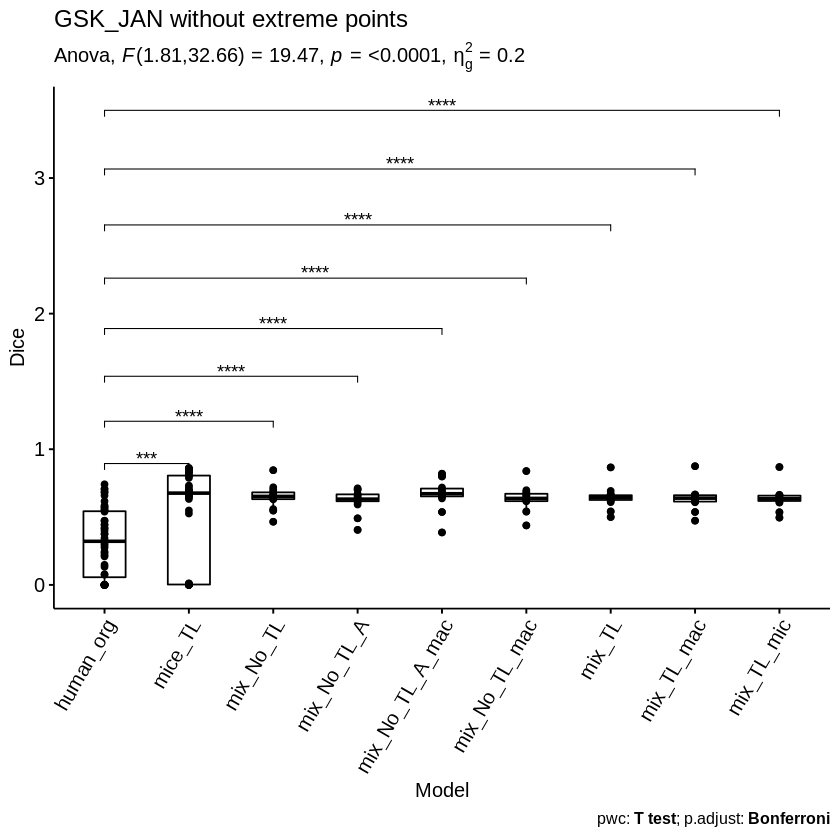

In [49]:
# Visualization: box plots with p-values
bxp <- ggboxplot(data, x = "Model", y = "dice", ylab = "Dice", add = "point", width = 0.5)
pwc <- pwc %>% add_xy_position(x = "Model")
bxp + 
  stat_pvalue_manual(pwc,step.increase = 0.2,hide.ns = TRUE) +
  labs(
    
    title = name,
    subtitle = get_test_label(res.aov, detailed = TRUE),
    caption = get_pwc_label(pwc)
  ) +
theme(axis.text.x = element_text(angle = 60, hjust = 1))


if (nrow(extremes)>0){
# Visualization: box plots with p-values
    bxp_no_extreme <- ggboxplot(eliminated, x = "Model", y = "dice", ylab = "Dice", add = "point", width = 0.5)
    pwc_no_extreme <- pwc_no_extreme %>% add_xy_position(x = "Model")
    bxp_no_extreme + 
      stat_pvalue_manual(pwc_no_extreme,step.increase = 0.2,hide.ns = TRUE) +
      labs(
          title = paste(name, "without extreme points", sep=" "),
          subtitle = get_test_label(res.aov, detailed = TRUE),
          caption = get_pwc_label(pwc)
          ) +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))
    }  

## Non-Parametric Tests

The repeated measures ANOVA makes the following assumptions about the data:

- __No significant outliers__ in any cell of the design.

- __Normality__: the dependent variable should be approximately normally distributed in each cell of the design. This can be checked using the Shapiro-Wilk normality test or by visual inspection using QQ plot.

- __Assumption of sphericity__: the variance of the differences between groups should be equal. It is automatically reported when using anova_test().

### Kruskal Test

In [50]:
kruskal.test(dice ~ Model, data = data)
cat("\n\n\n\n")

if (nrow(extremes)>0){
    kruskal.test(dice ~ Model, data = eliminated)
    cat("\n\n\n\n")
    }


	Kruskal-Wallis rank sum test

data:  dice by Model
Kruskal-Wallis chi-squared = 43.009, df = 8, p-value = 8.749e-07


As the p-value is less than the significance level 0.05, we can conclude that there are significant differences between the treatment groups.

From the output of the Kruskal-Wallis test, we know that there is a significant difference between groups, but we don’t know which pairs of groups are different.

It’s possible to use the function pairwise.wilcox.test() to calculate pairwise comparisons between group levels with corrections for multiple testing.


	Pairwise comparisons using Wilcoxon rank sum test 

data:  data$dice and data$Model 

                human_org mice_TL mix_No_TL mix_No_TL_A mix_No_TL_A_mac
mice_TL         0.00635   -       -         -           -              
mix_No_TL       0.00019   1.00000 -         -           -              
mix_No_TL_A     0.00019   1.00000 0.97586   -           -              
mix_No_TL_A_mac 0.00019   1.00000 0.90350   0.41332     -              
mix_No_TL_mac   0.00019   1.00000 1.00000   1.00000     0.61743        
mix_TL          0.00019   1.00000 0.97586   1.00000     0.40163        
mix_TL_mac      0.00019   1.00000 0.90350   1.00000     0.30607        
mix_TL_mic      0.00019   1.00000 0.90350   1.00000     0.22843        
                mix_No_TL_mac mix_TL  mix_TL_mac
mice_TL         -             -       -         
mix_No_TL       -             -       -         
mix_No_TL_A     -             -       -         
mix_No_TL_A_mac -             -       -         
mix_No_TL_mac   -  

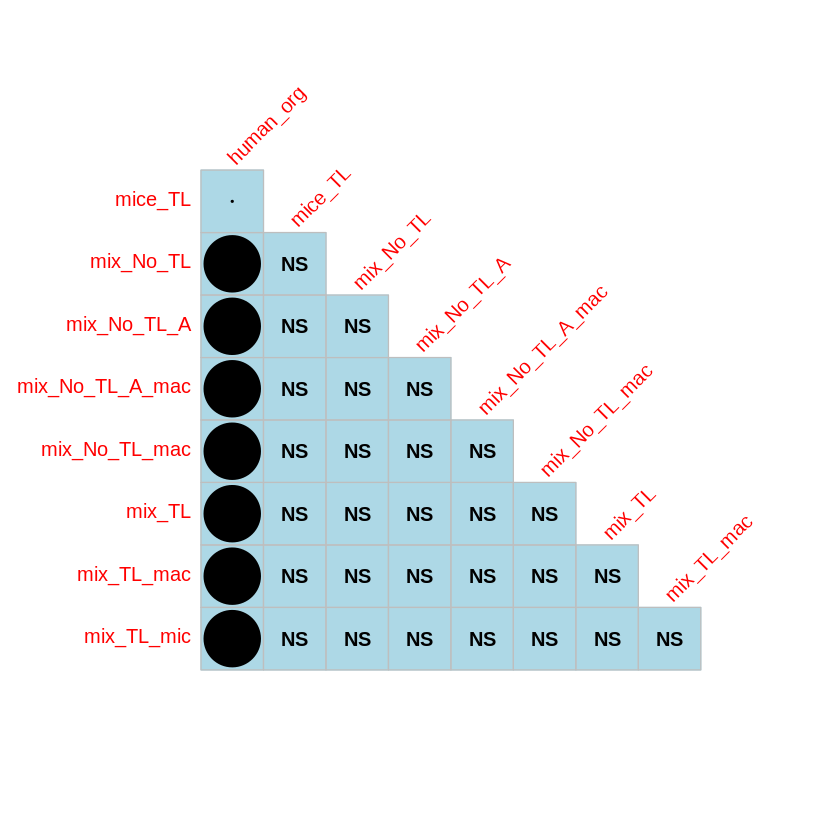

In [51]:
wilcox <- pairwise.wilcox.test(data$dice, data$Model,
                 p.adjust.method = "BH")
wilcox

wilcox$p.value[wilcox$p.value > 0.05] <- NA

my_transformed_pvals=-log10(wilcox$p.value)

corrplot(as.matrix(my_transformed_pvals),is.corr=F, type = "lower", na.label = "NS",
         col = c("black"), bg = "lightblue",cl.pos = "n",tl.srt = 45)

cat("\n\n\n\n")

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
W

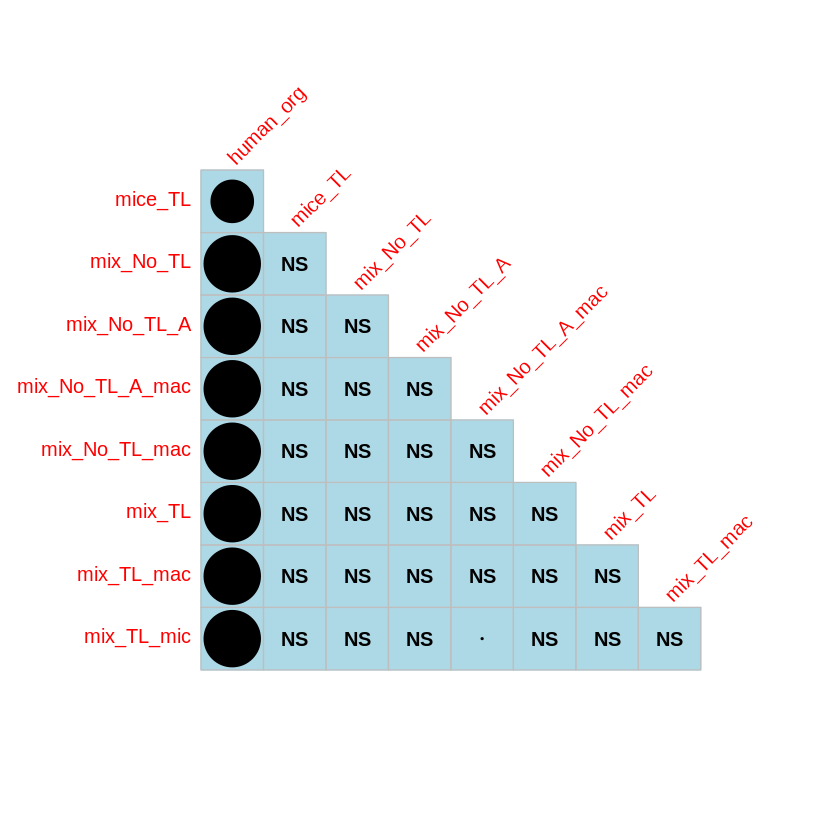

In [52]:
if (nrow(extremes)>0){
    wilcox_eliminated <- pairwise.wilcox.test(eliminated$dice, eliminated$Model,
                         p.adjust.method = "BH")
    wilcox_eliminated

    wilcox_eliminated$p.value[wilcox_eliminated$p.value > 0.05] <- NA

    my_transformed_pvals=-log10(wilcox_eliminated$p.value)

    corrplot(as.matrix(my_transformed_pvals),is.corr=F, type = "lower", na.label = "NS",
             col = c("black"), bg = "lightblue",cl.pos = "n",tl.srt = 45)
    }

The pairwise comparison shows a circle where models' results are significantly different (p < 0.05).
The bigger the difference, the bigger the circle. 'NS' means 'no significance'.